![bank_customer_stock_phooto](images/)

# Bank Customers Churn Model

**Author:** Steve Githinji
***

## Business Understanding

### Overview



***

### Business Problem

***

### Problem Question

***

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, 
    RFE, RFECV)

Below, the CSV containing the Bank Customer Churn data was opened as a pandas DataFrame, and its contents inspected.

In [2]:

data = pd.read_csv('data/Churn_Modelling.csv', index_col='RowNumber')

data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In the cell below, we check to see if there are any NaNs in the data:

In [5]:
data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
print('Raw counts: \n')
print(data['Exited'].value_counts())
print('Normalized counts: \n')
print(data['Exited'].value_counts(normalize=True))

Raw counts: 

0    7963
1    2037
Name: Exited, dtype: int64
Normalized counts: 

0    0.7963
1    0.2037
Name: Exited, dtype: float64


In [7]:
data.nunique().sort_values(ascending=False)

CustomerId         10000
EstimatedSalary     9999
Balance             6382
Surname             2932
CreditScore          460
Age                   70
Tenure                11
NumOfProducts          4
Geography              3
Exited                 2
IsActiveMember         2
HasCrCard              2
Gender                 2
dtype: int64

In [8]:
data['Geography'].value_counts()


France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Half of the records are for customers living in France, while.....

In [9]:
def view_salary_balance_range(df, salaries, balances):
    min_sal, max_sal = df[salaries].min(), df[salaries].max()
    min_bal, max_bal = df[balances].min(), df[balances].max()
    print(f"The dataset contains customers whose salaries range from €{min_sal} to €{max_sal}. Their account balances range from {min_bal} to {max_bal}.")

In [10]:
view_salary_balance_range(data, 'EstimatedSalary', 'Balance')

The dataset contains customers whose salaries range from €11.58 to €199992.48. Their account balances range from 0.0 to 250898.09.


## Data Preparation

The prediction target for this analysis is the churn status of a customer, described in the column `Exited`. Therefore the data was separated into X and y accordingly. The `CustomerId` and `Surname` columns are data artifacts and not true features. Therefore they were not included as predictors.

In [11]:
# Drop irrelevant columns  and assign predictors to X
X = data.drop(columns=['Exited', 'CustomerId', 'Surname'], axis=1)

# Assign outcome variable 'Exited' to y
y = data['Exited']

Next, we separate the data into a train set (75% of the full dataset) and a test set (25% of the full dataset) prior to performing any preprocessing steps. This was done before data preparation to avoid data leakage.  The treatment of the test data is therefore as similar as possible to how genuinely unknown data should be treated.

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

### Categorical Features

 If we feed the current `X_train` into our scikit-learn Machine Learning models, it would crash. Hence convert all the categorical features into numbers.

In [13]:
# Subset categorical columns into a new DataFrame 
X_train_categorical = X_train.select_dtypes(exclude=['int64', 'float64']).copy()

# View categorical features
X_train_categorical.columns

Index(['Geography', 'Gender'], dtype='object')

In [14]:

X_train_ohe = pd.DataFrame(
    pd.get_dummies(X_train_categorical, drop_first=True))
X_train_ohe

,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,
2263,0,0,1
1455,0,1,0
3902,0,1,1
6247,0,0,1
1332,1,0,1
...,...,...,...
1294,0,0,1
4024,0,0,1
7260,0,1,1


### Normalization

Use the 

In [15]:
numeric_features = ['CreditScore', 'Age','Tenure', 'Balance', 'NumOfProducts',
                    'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
X_train_numeric = X_train[numeric_features].copy()
X_train_numeric.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,
1294,641,30,2,87505.47,2,0,1,7278.57
4024,535,38,8,85982.07,1,1,0,9238.35
7260,625,32,7,106957.28,1,1,1,134794.02
5201,512,42,9,93955.83,2,1,0,14828.54
3776,528,22,5,93547.23,2,0,1,961.57


Use the MinMaxScaler to scale the training set.

In [16]:
# Instantiate scaler
scaler = MinMaxScaler()

# Fit the scaler on the numerical data
scaler.fit(X_train_numeric)

#
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numeric),
    # Specify index to ensure we can concatenate with other columns
    index=X_train_numeric.index,
    columns=X_train_numeric.columns
)
X_train_scaled

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,
2263,0.444,0.337838,0.2,0.633911,0.000000,1.0,0.0,0.132222
1455,0.342,0.216216,0.7,0.319280,0.000000,1.0,1.0,0.101183
3902,0.450,0.162162,0.2,0.000000,0.333333,1.0,1.0,0.411140
6247,0.566,0.297297,0.4,0.679710,0.000000,0.0,1.0,0.173331
1332,0.998,0.256757,0.7,0.647546,0.333333,1.0,1.0,0.086430
...,...,...,...,...,...,...,...,...
1294,0.582,0.162162,0.2,0.395000,0.333333,0.0,1.0,0.036342
4024,0.370,0.270270,0.8,0.388123,0.000000,1.0,0.0,0.046143
7260,0.550,0.189189,0.7,0.482806,0.000000,1.0,1.0,0.674050


Finally, concatenate the preprocessed Ddtaframes `X_tain_scaled` and `X_train_ohe` to a new dataframe `X_train_full`.

In [17]:
#
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)

#
X_train_full

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
2263,0.444,0.337838,0.2,0.633911,0.000000,1.0,0.0,0.132222,0,0,1
1455,0.342,0.216216,0.7,0.319280,0.000000,1.0,1.0,0.101183,0,1,0
3902,0.450,0.162162,0.2,0.000000,0.333333,1.0,1.0,0.411140,0,1,1
6247,0.566,0.297297,0.4,0.679710,0.000000,0.0,1.0,0.173331,0,0,1
1332,0.998,0.256757,0.7,0.647546,0.333333,1.0,1.0,0.086430,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1294,0.582,0.162162,0.2,0.395000,0.333333,0.0,1.0,0.036342,0,0,1
4024,0.370,0.270270,0.8,0.388123,0.000000,1.0,0.0,0.046143,0,0,1
7260,0.550,0.189189,0.7,0.482806,0.000000,1.0,1.0,0.674050,0,1,1


The same preprocessing process was applied to the test data, so that models' performance can be evaluated on unseen data.

In [18]:
# Subset categorical columns into a new DataFrame 
X_test_categorical = X_test.select_dtypes(exclude=['int64', 'float64']).copy()

# Handling categorical data
X_test_ohe = pd.DataFrame(
    pd.get_dummies(X_test_categorical, drop_first=True))

# Normalization numerical predictors
X_test_numeric = X_test[numeric_features].copy()
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numeric),
    index=X_test_numeric.index,
    columns=X_test_numeric.columns
)

# Concatenating categorical and numeric data
X_test_full = pd.concat([X_test_scaled, X_test_ohe], axis=1)

# Preview DataFrame
X_test_full.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
7653,0.708,0.081081,0.2,0.668963,0.333333,1.0,0.0,0.914004,0,0,1
7828,0.510,0.310811,1.0,0.000000,0.333333,0.0,1.0,0.486107,0,0,1
5170,0.602,0.175676,0.7,0.622969,0.333333,1.0,0.0,0.649638,1,0,1
9313,0.458,0.297297,1.0,0.204976,0.333333,1.0,0.0,0.093626,1,0,1
4021,0.742,0.324324,0.4,0.464657,0.000000,0.0,0.0,0.005883,0,0,1


## Modelling

### Model 1: Baseline Logistic Regression Model

After preprocessing all the columns, an initial baseline model was built. This model represents a naive reference point for evaluating the performance of more sophisticated models that will be built. It provided a benchmark or starting point for comparison and established initial metrics that other models tried to improve on.

The baseline model used is a Logistic Regression model. In scikit-learn, this is done by first creating an instance of the `LogisticRegression` class. From there, use the `.fit()` method from the class instance to fit a model to the training data.

In [19]:
# Instantiate the model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit model on training features
baseline_model_log = logreg.fit(X_train_full, y_train)

How does the model perform on the training and test data?

To answer this, first predict class labels for samples in `X_train_full` and `X_test_full` using the `predict()` method.

In [20]:
# Generate predictions for both sets
y_hat_train = logreg.predict(X_train_full)
y_hat_test = logreg.predict(X_test_full)

To evaluate the model, a function that plots a confusion matrix of the test data predictions was defined. Another function that outputs evaluation metrics was also defined.

In [21]:
# Function that plots confusion matrix
def cnf_matrix(model, y_test, y_test_preds):
    """
    Function takes in a model, label data and its corresponding
    predictions, then plots a confusion matrix
    """
    cnf_matrix = confusion_matrix(y_test, y_test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)

In [22]:
# Function that outputs evaluation metrics
def print_metrics(y_train, y_hat_train, y_test, y_hat_test):
    """
    Function takes in actual y values and their model predictions
    for training  and test data and outputs precision, accuracy
    and RMSE metrics
    """
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('\n')
    
    print('Training RMSE:', mean_squared_error(y_train, y_hat_train, squared=False))
    print('Testing RMSE:', mean_squared_error(y_test, y_hat_test, squared=False))

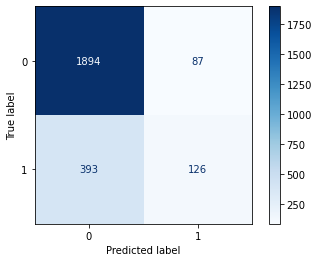

In [23]:
# Call on a function to display model's confusion matrix
cnf_matrix(logreg, y_test, y_hat_test)

In [24]:
# Use print_metrics function to display evaluation metrics
print_metrics(y_train, y_hat_train, y_test, y_hat_test)

Training Precision:  0.5813084112149532
Testing Precision:  0.5915492957746479


Training Accuracy:  0.8092
Testing Accuracy:  0.808


Training RMSE: 0.4368065933568311
Testing RMSE: 0.4381780460041329


The model is mildly overfitting as seen with the slightly `higher Testing RMSE`. The model is about `81% accurate` in its predictions for both the training and test data. It has `precision` scores of `58%` and `59%` on the training and test data respectively. Moving forward, the objective is to improve on these classification metrics. 

The target is an accuracy of 90%, precision of 80% and reduce the RMSE as much as possible. To do this, there was an iteration through several models to try and achieve these targets.

### Model 2: K-Nearest Neighbors

After the baseline model, the first model built using the distance-base K-Nearest Neighbors (KNN) classifier. The default values were used such as `n_neighbors` of 5 and `minkowski` as the distance computation metric.

In [25]:
# Instantiate classifier implementing k-nearest neighbors vote
clf = KNeighborsClassifier()

# Fit the classifier on the training data
clf.fit(X_train_full, y_train)

# Generate predictions to training data/labels
y_train_knn_preds = clf.predict(X_train_full)
y_test_knn_preds = clf.predict(X_test_full)

To evaluate this vanilla KNN model, plot the confusion matrix and display precision, accuracy and RMSE classification metrics.

Training Precision:  0.7844925883694412
Testing Precision:  0.547945205479452


Training Accuracy:  0.8641333333333333
Testing Accuracy:  0.8036


Training RMSE: 0.36860095858077563
Testing RMSE: 0.44317039612320674


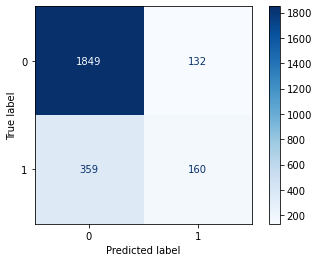

In [28]:
# Compute evaluation metrics
print_metrics(y_train, y_train_knn_preds, y_test, y_test_knn_preds)

# Plot confusion matrix of test set
cnf_matrix(clf, y_test, y_test_knn_preds)

This model did not show an improvement in the test set compared to the baseline model. This might be because only the default hyperparameters were used. In the next model, a more advanced method was used to search for the optimmum hyperparameters.

### Model 3: KNN with Parameter Tuning

Here we try to improve the performance of the KNN model. This was done by finding an optimal value of K through some iterative investigation. The best way to find an optimal value for K is to choose a minimum and maximum boundary and try them all!

In [28]:
# Instantiate the model
knn = KNeighborsClassifier()

# Define a range for K values
k_range = list(range(1, 31))

# Add K values to be iterated to a dictionary
param_grid = dict(n_neighbors=k_range)

# Instantiate GridSearchClass
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# Fitting the model for grid search
grid_search=grid.fit(X_train_full, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.3min finished


Once the model is fit, we can find the optimal parameter of K and the best score obtained through GridSearchCV.

In [29]:
# Use best_params_ method to parameters for this estimator
print(grid_search.best_params_)

# Get mean cross-validated score of the best_estimator
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

{'n_neighbors': 7}
Accuracy for our training dataset with tuning is : 81.88%


After parameter tuning, we now have the best hyperparameter of K=7, this can be used to fit a KNN model and check its accuracy on the unseen test dataset.

In [30]:
# Instantiate the model
knn_k_7 = KNeighborsClassifier(n_neighbors=7)

# Fit model on the training data
knn_k_7.fit(X_train_full, y_train)

# Predict training
y_train_k7_preds = knn_k_7.predict(X_train_full)

# Predict test
y_test_k7_preds = knn_k_7.predict(X_test_full)

To evaluate this tuned KNN model, plot the confusion matrix and display precision, accuracy and RMSE classification metrics.

In [32]:
# Compute evaluation metrics
print_metrics(y_train, y_train_k7_preds, y_test, y_test_k7_preds)

Training Precision:  0.7694300518134715
Testing Precision:  0.5714285714285714


Training Accuracy:  0.8530666666666666
Testing Accuracy:  0.8072


Training RMSE: 0.3833188403057347
Testing RMSE: 0.43908996800200295


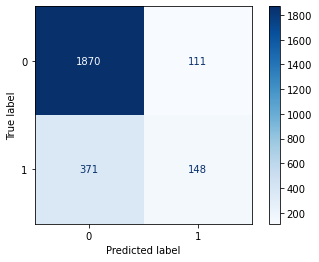

In [33]:
# Plot confusion matrix of test set
cnf_matrix(knn_k_7, y_test, y_test_k7_preds)

There is an improvement in performance on the test data evaluation metrics. Precision increased from 54% to 57%, accuracy from 80% to 81% while RMSE reduced from 0.44 to 0.43. Parameter tuning seems to have a had a positive effect on model performance.

Next, ensemble methods were used to try and improve these metrics.


## Model 4: Random Forest

Here Random Forest algorithm was built which is an ensemble of decision trees. A RandomForestClassifier was instantiated and fit, and the number of estimators set to 100 and max depth to 5. Then, the model was fit to the training data.

In [34]:
# Instantiate and fit a RandomForestClassifier 
forest = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=23)
forest.fit(X_train_full, y_train)

# Generate training and test set predictions
y_train_rf_preds = forest.predict(X_train_full)
y_test_rf_preds = forest.predict(X_test_full)

To evaluate this Random Forest model, plot the confusion matrix and display precision, accuracy and RMSE classification metrics.

Training Precision:  0.8976660682226212
Testing Precision:  0.8415841584158416


Training Accuracy:  0.8566666666666667
Testing Accuracy:  0.8476


Training RMSE: 0.37859388972001823
Testing RMSE: 0.3903844259188627


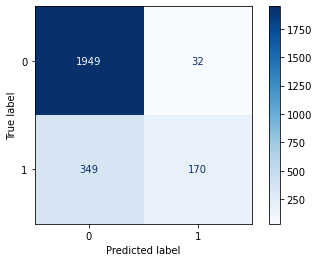

In [36]:
# Compute evaluation metrics
print_metrics(y_train, y_train_rf_preds, y_test, y_test_rf_preds)

# Plot confusion matrix of test set
cnf_matrix(forest, y_test, y_test_rf_preds)

The RandomForestClassifier performed much better than the tuned KNN model. Accuracy of test set predictions increased from 81% to 85% while precision from 57% to 84%. There was also a decrease in RMSE from 0.44 to 0.39.

Below, a way to potentially improve the model's performance is to find good parameters to set when creating the model.

## Model 5: Random Forest with Tuned Hyperparameters

Here an attempt was made to find the optimum parameters to use in the model. First, a the param_grid dictionary was defined. In this dictionary, each key represents a parameter we want to tune and each corresponding value is a list of every parameter value we'd like to check for that parameter.

In [37]:
# Dictionary of parameters to tune
rf_param_grid = {
    "n_estimators": [30, 100, 120],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 6, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 6]}

K-Fold cross-validation was implemented during this step. Set K = 3, meaning that 3 different models were trained for each unique combination of parameters.

How many different decision trees will GridSearchCV have to train in order to try every possible combination and find the best parameter choices?

In [40]:
# Compute number of models iterated over to get best combination
num_decision_trees = 3 * 3 * 2 * 4 * 2 * 2

print(
    f"Grid Search will have to search through {num_decision_trees} different permutations."
)

Grid Search will have to search through 288 different permutations.


Tune the model parameters through an exhaustive search by instantiating and fitting the GridSearchCV class.

In [41]:
# Instantiate model to be tuned
rf = RandomForestClassifier(random_state=23)

# Instantiate and fit GridSearchCV to training data
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_full, y_train)

# Print parameter setting that gave the best results and its score
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 86.61%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


Using the optimal parameters from the search above, instantiate a RandomForestClassifier, fit it on the training set and generate predictions.

In [42]:
# Instantiate the model with optimized hyperparameters
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None,
                                  min_samples_leaf=3, min_samples_split=5, 
                                  n_estimators=100)

# Fit the model on the training data
rf_tuned.fit(X_train_full, y_train)

# Generate predictions
y_train_rf2_preds = rf_tuned.predict(X_train_full)
y_test_rf2_preds = rf_tuned.predict(X_test_full)

Plot a confusion matrix and display precision, accuracy and RMSE classification metrics to evaluate performance of the model.

Training Precision:  0.9605734767025089
Testing Precision:  0.7370030581039755


Training Accuracy:  0.9346666666666666
Testing Accuracy:  0.8544


Training RMSE: 0.2556038601690775
Testing RMSE: 0.38157568056677826


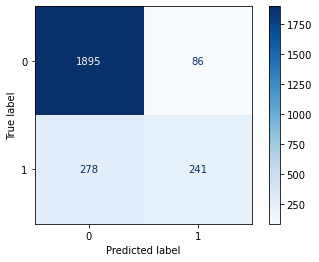

In [43]:
# Compute evaluation metrics
print_metrics(y_train, y_train_rf2_preds, y_test, y_test_rf2_preds)

# Plot confusion matrix of test set
cnf_matrix(rf_tuned, y_test, y_test_rf2_preds)

There is an increase in accuracy but a decrease in precision. There is a noticeable increase in overfitting in this model as seen in the increase in the difference between training and test set metrics. 

### Model 6: Random Forest with tuned parameters

To reduce overfitting, feature selection was done below using a Filter Method called `SelectKBest`. This transformer uses a particular statistic to compare features to the target one by one. Then it selects the top `k` features based on this statistic. The default `k` is 10.
Below `f_regression` statistic was tried.

In [45]:
# Create an instance of SelectKBest with f_regression scoring function
selector = SelectKBest(score_func=f_regression, k=9)

# Fit and transform the feature selector to the data
X_train_k_best = selector.fit_transform(X_train_full, y_train)

# Transform the testing data
X_test_k_best = selector.transform(X_test_full)

`X_train_k_best` and `X_test_k_best` now contain our top k features. Next create an instance of `GridSearchCV`, passing the random forest classifier and the parameter grid. We also specify cv=3 to perform 3-fold cross-validation.

Then fit the grid search to the training data using the fit method. This will perform an exhaustive search over the specified parameter grid, training and evaluating the random forest classifier for each parameter combination. After the grid search is complete, retrieve the best parameter combination using best_params_ and its score using best_score_ method.

In [47]:
# Create a random forest classifier
rf3 = RandomForestClassifier(random_state=23)

# Create an instance of GridSearchCV
rf3_grid_search = GridSearchCV(rf3, rf_param_grid, cv=3)

# Fit the grid search to the training data
rf3_grid_search.fit(X_train_k_best, y_train)

# Print the best parameter combination and its score
print(f"Training Accuracy: {rf3_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf3_grid_search.best_params_}")

Training Accuracy: 86.63%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 120}


Use the optimized hyperparameters from the GridSearch to build a model.

In [51]:
# Create a random forest classifier
rf3_tuned = RandomForestClassifier(criterion='gini', max_depth=10,
                                  min_samples_leaf=3, min_samples_split=10, 
                                  n_estimators=120)

# Fit classifier on training data
rf3_tuned.fit(X_train_k_best, y_train)

# Generate predictions
y_train_rf3_preds = rf3_tuned.predict(X_train_k_best)
y_test_rf3_preds = rf3_tuned.predict(X_test_k_best)

Plot a confusion matrix and display precision, accuracy and RMSE classification metrics to evaluate performance of the model.

Training Precision:  0.8894967177242888
Testing Precision:  0.7453416149068323


Training Accuracy:  0.8925333333333333
Testing Accuracy:  0.8556


Training RMSE: 0.3278210894171799
Testing RMSE: 0.38


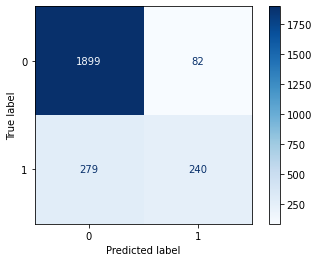

In [52]:
# Compute evaluation metrics
print_metrics(y_train, y_train_rf3_preds, y_test, y_test_rf3_preds)

# Plot confusion matrix of test set
cnf_matrix(rf3_tuned, y_test, y_test_rf3_preds)

There is a slight decrease in overfitting in this model as seen in the decrease in the difference between training and test RMSE. Testing set accuracy and precision have increased slightly.

## Results

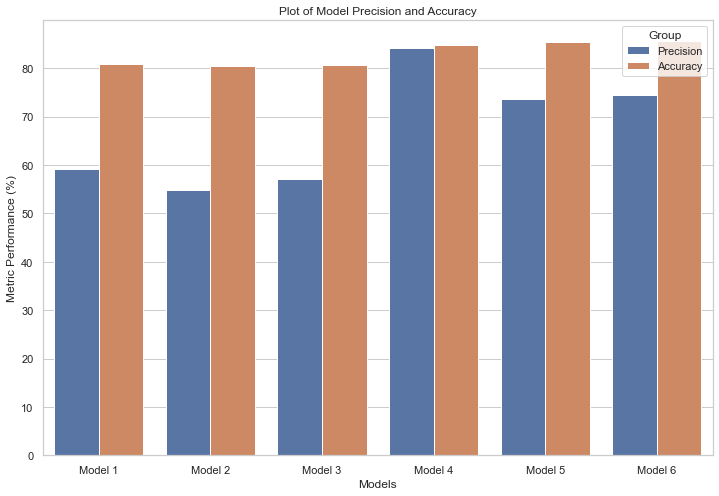

In [41]:
# Create a sample dataframe
data = {'Category': ['Model 1', 'Model 1', 'Model 2', 'Model 2', 'Model 3','Model 3',
                     'Model 4', 'Model 4', 'Model 5', 'Model 5', 'Model 6', 'Model 6'],
        'Group': ['Precision', 'Accuracy', 'Precision', 'Accuracy', 'Precision', 'Accuracy',
                 'Precision', 'Accuracy', 'Precision', 'Accuracy', 'Precision', 'Accuracy'],
        'Value': [59.2, 80.8, 54.8, 80.4, 57.1, 80.7, 84.2, 84.8, 73.7, 85.4, 74.5, 85.6]}
df = pd.DataFrame(data)

# Plot grouped barplot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

sns.barplot(x='Category', y='Value', hue='Group', data=df)
plt.xlabel('Models')
plt.ylabel('Metric Performance (%)')
plt.title('Plot of Model Precision and Accuracy')

plt.legend(title='Group')
plt.show()

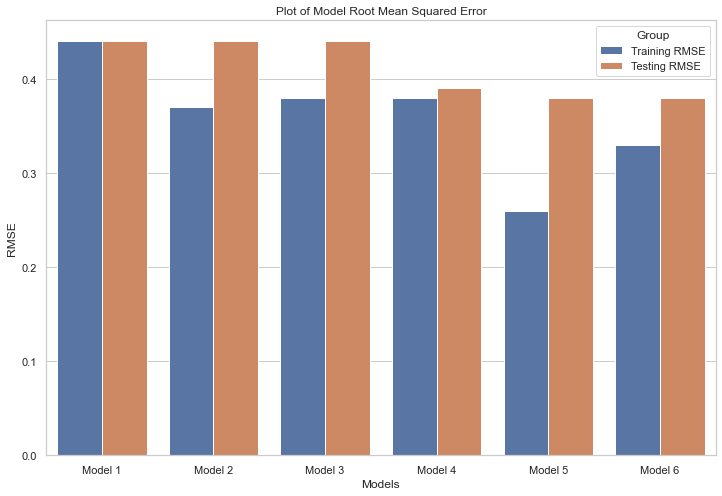

In [46]:
# Create a sample dataframe
data = {'Category': ['Model 1', 'Model 1', 'Model 2', 'Model 2', 'Model 3','Model 3',
                     'Model 4', 'Model 4', 'Model 5', 'Model 5', 'Model 6', 'Model 6'],
        'Group': ['Training RMSE', 'Testing RMSE', 'Training RMSE', 'Testing RMSE', 'Training RMSE', 'Testing RMSE',
                 'Training RMSE', 'Testing RMSE', 'Training RMSE', 'Testing RMSE', 'Training RMSE', 'Testing RMSE'],
        'Value': [0.44, 0.44, 0.37, 0.44, 0.38, 0.44, 0.38, 0.39, 0.26, 0.38, 0.33, 0.38]}
df = pd.DataFrame(data)

# Plot grouped barplot using Seaborn
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

sns.barplot(x='Category', y='Value', hue='Group', data=df)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Plot of Model Root Mean Squared Error')

plt.legend(title='Group')
plt.show()